<a href="https://colab.research.google.com/github/soerenml/tensorflow-certificate/blob/master/Time_series_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series data

Characteristics of time series:

*   Trend
*   Seasonality
*   Autocorrelation
*   Noise

Those characteristics can be stationary or non-stationary. Stationarity characterizes time series which do not change overtime. Such time series have no trends or seasonality. Hence, they are identically distrubuted - but not independent. A time series which is non-stationary would include the dot.com bubble.

Trends can have a significant impact on the mean. I.e. compare the average down jones between 1984 and 2020. Seasonality on the other side can have a significant impact on the variance. I.e. the great sell-off in December creates sign. changes in variance.




# Create synthetic data

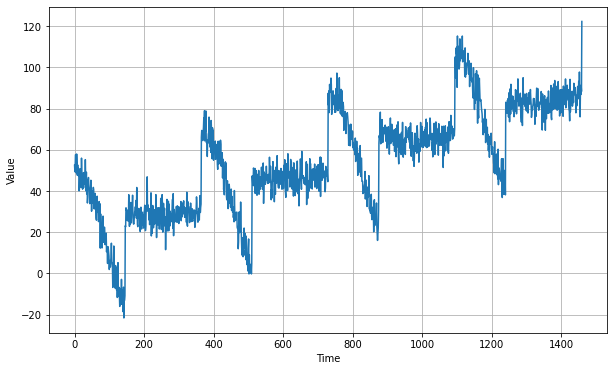

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

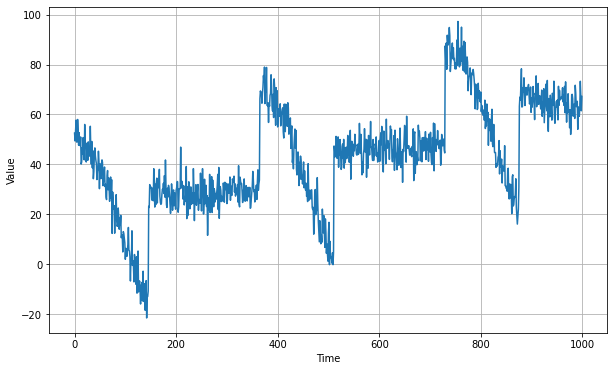

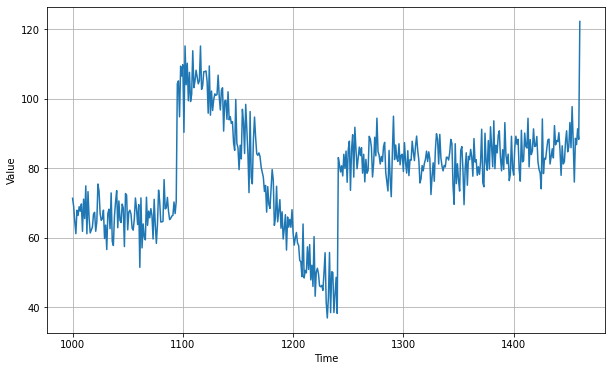

In [3]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

In [4]:
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.keras.metrics import mean_absolute_error

def mse_mae(x_valid, pred):
  print("MSE: {}".format(round(mean_squared_error(x_valid, pred).numpy())))
  print("MAE: {}".format(round(mean_absolute_error(x_valid, pred).numpy())))

# Statistical modelling

## Naive forecast

Predict t with t-1.

In [5]:
naive_forecast = series[split_time - 1:-1]

MSE: 62.0
MAE: 6.0


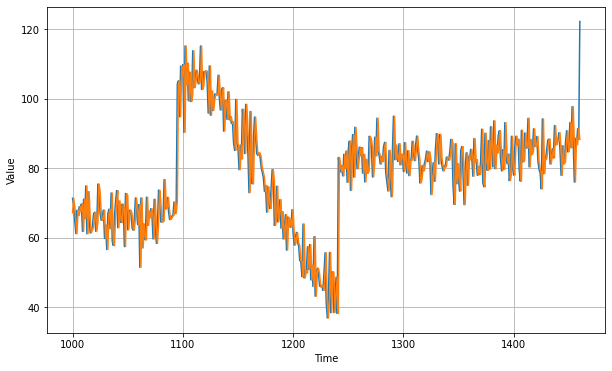

In [6]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

mse_mae(x_valid, naive_forecast)

# Moving average

Calculate a moving window to predict t+1.

The problem: trend and seasonality heavily affecting our forecast.

MSE: 107.0
MAE: 7.0


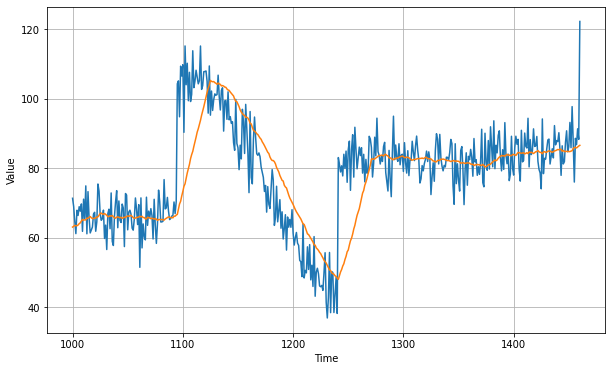

In [7]:
def moving_average_forecast(series, window_size):
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

mse_mae(x_valid, moving_avg)

# Differenciating

We will use differenciating to get rid of trend and seasonality. To do so we calculate t - t(-365).

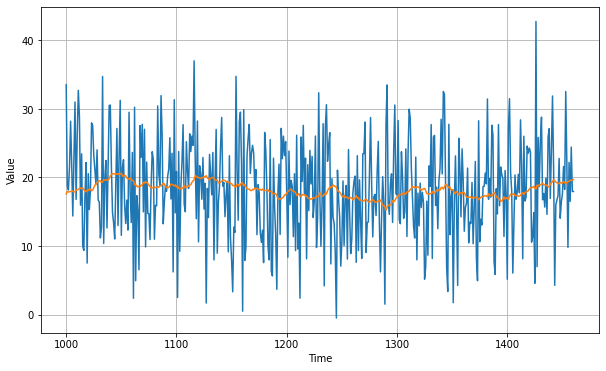

In [8]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

# Add a moving average of 50 days.
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

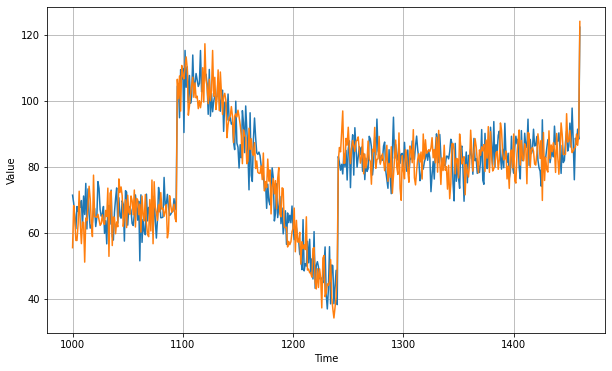

In [9]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [10]:
mse_mae(x_valid, diff_moving_avg_plus_past)

MSE: 53.0
MAE: 6.0


# Prepare data for DL

In [11]:
# Create ten datapoints.
dataset = tf.data.Dataset.range(10)
# Create a window of 5 with shift 1 not allowing windows with < 5 items.
dataset = dataset.window(5, shift=1, drop_remainder=True)
# Use flat_map if you want to make sure that the order of your dataset stays the same.
dataset = dataset.flat_map(lambda window: window.batch(5))
# Split features and labels.
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
# Suffle the data.
dataset = dataset.shuffle(buffer_size=10)
# Define batches and prefetch the data.
dataset = dataset.batch(2).prefetch(1)
for x,y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())

x =  [[0 1 2 3]
 [1 2 3 4]]
y =  [[4]
 [5]]
x =  [[4 5 6 7]
 [5 6 7 8]]
y =  [[8]
 [9]]
x =  [[3 4 5 6]
 [2 3 4 5]]
y =  [[7]
 [6]]


# Using a simple linear regression for forecasting

## Ingest data

In [12]:
# todo - why are we using window size + 1?
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

# Ingest data with tf.Data
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

We are creating a single layer NN. Technically, a simple linear regression.

In [13]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

# Define the model
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])
model.compile(loss="mse",
              optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

# Print weights
print("Layer weights {}".format(l0.get_weights()))

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Layer weights [array([[-0.03099019],
       [ 0.05287858],
       [-0.0281891 ],
       [-0.04252807],
       [ 0.04736267],
       [-0.03565158],
       [ 0.00201793],
       [ 0.07108986],
       [ 0.04008504],
       [-0.0493759 ],
       [-0.03059496],
       [-0.02996014],
       [-0.05436229],
       [ 0.1308528 ],
       [-0.03466677],
       [ 0.14112058],
       [-0.02781324],
       [ 0.15363382],
       [ 0.25277856],
       [ 0.4757601 ]], dtype=float32), array([0.01624059], dtype=float32)]


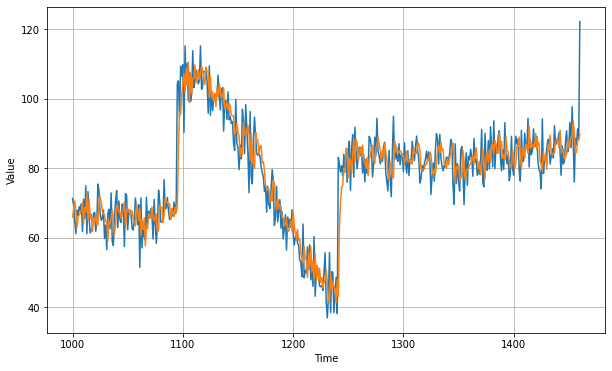

In [14]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

mse_mae(x_valid, results)

# Using a deep neural network

In [36]:
_EPOCHS = 100
_WINDOW_SIZE = 20

inputs = tf.keras.Input(shape=[_WINDOW_SIZE])
l1 = tf.keras.layers.Dense(10, activation="relu")(inputs)
l2 = tf.keras.layers.Dense(10, activation="relu")(l1)
outputs = tf.keras.layers.Dense(1)(l2)

model = keras.Model(inputs=inputs, outputs=outputs, name="dnn_time_series")
model.summary()

# Callback
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
model.compile(loss="mse",
              optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9))
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

Model: "dnn_time_series"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_17 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 11        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

mse_mae(x_valid, results)

## Pick the best learning rate

             lrs         loss
0   1.000000e-08  9333.739258
1   1.122018e-08  6711.405762
2   1.258925e-08  5218.985840
3   1.412538e-08  4457.510742
4   1.584893e-08  3919.495605
..           ...          ...
95  5.623413e-04   448.644043
96  6.309573e-04   446.412689
97  7.079458e-04   445.437714
98  7.943282e-04   445.066010
99  8.912509e-04   445.092529

[100 rows x 2 columns]
65    0.000018
Name: lrs, dtype: float64 20


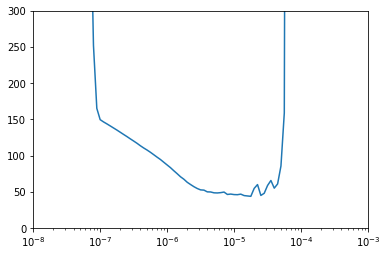

In [38]:
import pandas as pd
lrs = 1e-8 * (10 ** (np.arange(_EPOCHS) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

df = pd.DataFrame({'lrs':lrs, 'loss': history.history["loss"]})
print(df)
min_loss = df['loss'].min()
best_learning_rate = df['lrs'][df['loss']==df['loss'].min()]
print(best_learning_rate, 20)

In [41]:
# Retrain model with new learning rate
model.compile(loss="mse",
              optimizer=tf.keras.optimizers.SGD(lr=best_learning_rate.iloc[0], momentum=0.9))
history = model.fit(dataset, epochs=100, verbose=0)

MSE: 42.0
MAE: 5.0


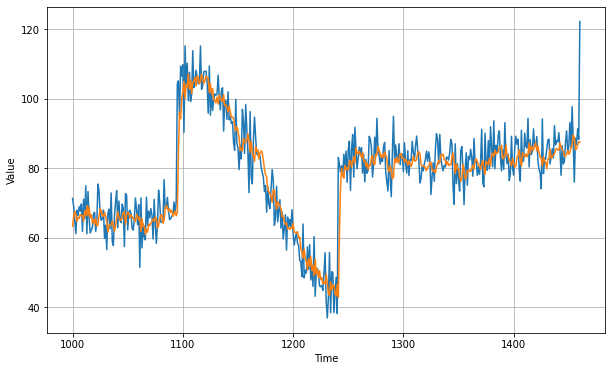

In [42]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

mse_mae(x_valid, results)